#### Building a SentencePiece-Style Tokenizer from Scratch

Input: ▁lowest
SentencePiece Tokens: ['▁lowest']
Vocabulary Size: 324


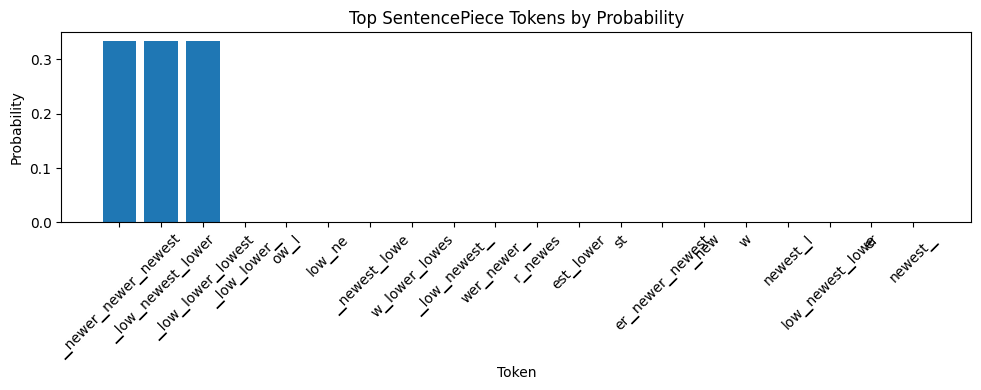

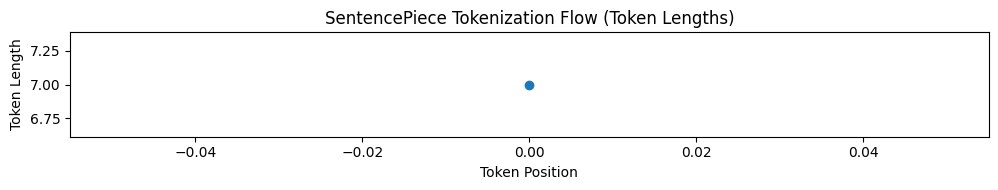

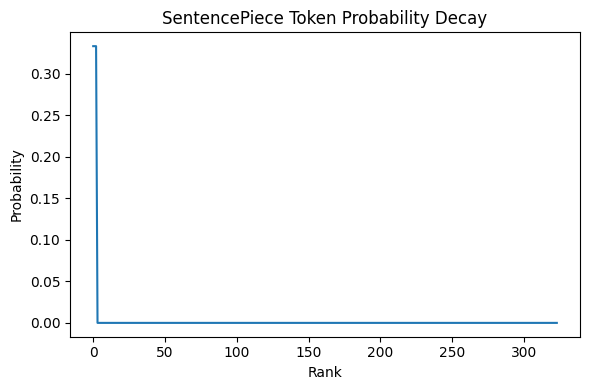

In [ ]:
from collections import Counter
import math
import matplotlib.pyplot as plt

corpus = [
    "low lower lowest",
    "newer newer newest",
    "low newest lower"
]

def preprocess(corpus):
    return ["▁" + s.replace(" ", "▁") for s in corpus]

corpus = preprocess(corpus)

def build_initial_vocab(corpus):
    vocab = set()
    word_freq = Counter()

    for sent in corpus:
        word_freq[sent] += 1
        for i in range(len(sent)):
            for j in range(i + 1, len(sent) + 1):
                vocab.add(sent[i:j])

    return list(vocab), word_freq

vocab, word_freq = build_initial_vocab(corpus)


def init_probs(vocab):
    p = 1 / len(vocab)
    return {t: p for t in vocab}

token_probs = init_probs(vocab)

def sp_tokenize(sentence, token_probs, alpha=0.0):
    n = len(sentence)
    dp = [(-math.inf, []) for _ in range(n + 1)]
    dp[0] = (0, [])

    for i in range(n):
        if dp[i][0] == -math.inf:
            continue
        for token, prob in token_probs.items():
            if sentence.startswith(token, i):
                j = i + len(token)
                score = dp[i][0] + math.log(prob) - alpha * len(token)
                if score > dp[j][0]:
                    dp[j] = (score, dp[i][1] + [token])

    return dp[n][1]

def train_sentencepiece(word_freq, token_probs, iters=5):
    for _ in range(iters):
        counts = Counter()

        for sent, freq in word_freq.items():
            tokens = sp_tokenize(sent, token_probs)
            for t in tokens:
                counts[t] += freq

        total = sum(counts.values())
        for t in token_probs:
            token_probs[t] = counts[t] / total if t in counts else 1e-9

    return token_probs

token_probs = train_sentencepiece(word_freq, token_probs)

sample = "lowest"
sample = "▁" + sample

tokens = sp_tokenize(sample, token_probs)

print("Input:", sample)
print("SentencePiece Tokens:", tokens)
print("Vocabulary Size:", len(token_probs))

top = sorted(token_probs.items(), key=lambda x: x[1], reverse=True)[:20]

labels = [t[0] for t in top]
values = [t[1] for t in top]

plt.figure(figsize=(10, 4))
plt.bar(labels, values)
plt.title("Top SentencePiece Tokens by Probability")
plt.xlabel("Token")
plt.ylabel("Probability")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

lengths = [len(t) for t in tokens]

plt.figure(figsize=(10, 2))
plt.plot(range(len(tokens)), lengths, marker="o")
plt.title("SentencePiece Tokenization Flow (Token Lengths)")
plt.xlabel("Token Position")
plt.ylabel("Token Length")
plt.tight_layout()
plt.show()

probs = sorted(token_probs.values(), reverse=True)

plt.figure(figsize=(6, 4))
plt.plot(probs)
plt.title("SentencePiece Token Probability Decay")
plt.xlabel("Rank")
plt.ylabel("Probability")
plt.tight_layout()
plt.show()
